# Heisenberg XXX model

$$ H_{\text{TFIM}} = \sum_{j=1}^{L}(X_jX_{j+1}+Y_jY_{j+1}+Z_jZ_{j+1}) $$

pip install qrisp

https://www.qrisp.eu


In [90]:
from qrisp.operators import X, Y, Z
from qrisp.vqe.problems.heisenberg import *
import matplotlib.pyplot as plt
from qrisp import QuantumVariable, conjugate
from qrisp.qite import QITE
import time
import sympy as sp


def run_param_rc(fontsize = 30):
        import matplotlib.pyplot as plt
        plt.rcParams['axes.labelsize'] = fontsize
        plt.rcParams['axes.titlesize'] = fontsize
        plt.rcParams['font.size'] = fontsize
        #set_matplotlib_formats('pdf', 'png')
        plt.rcParams['savefig.dpi'] = 75
        plt.rcParams['lines.linewidth'] = 2.0
        plt.rcParams['lines.markersize'] = 8
        plt.rcParams['legend.fontsize'] = 12
        plt.rcParams['legend.labelspacing'] = .3
        plt.rcParams['legend.columnspacing']= .3
        plt.rcParams['legend.handletextpad']= .1
        plt.rcParams['text.usetex'] = True
        plt.rcParams['font.family'] = "serif"
        plt.rcParams['font.serif'] = "cm"
run_param_rc(20)

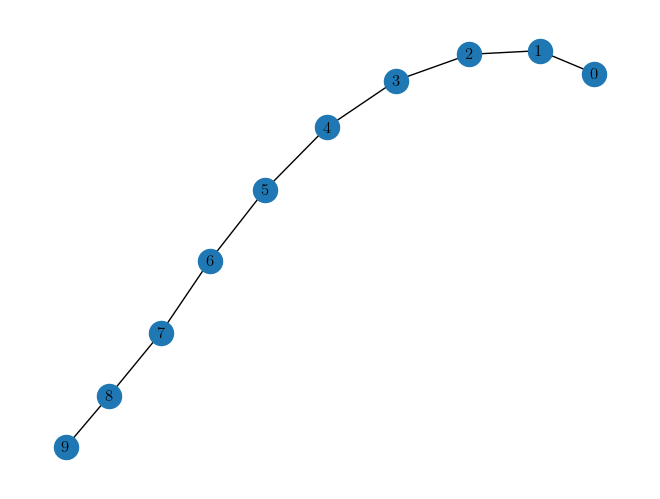

In [2]:
import networkx as nx
import numpy as np

# Create a graph
L = 10
G = nx.Graph()
G.add_edges_from([(k,k+1) for k in range(L-1)]) 
nx.draw(G, with_labels=True)

## Define Heisenberg Hamiltonian and (rescaled) Hamiltonian evolution

First order Trotter-Suzuki
$$
e^{it(A+B)} =(e^{i\frac{t}{N}A} e^{i\frac{t}{N}B})^N 
$$

Second order Trotter-Suzuki
$$
e^{it(A+B)} =(e^{i\frac{t}{2N}A} e^{i\frac{t}{N}B} e^{i\frac{t}{2N}A})^N 
$$

In [76]:
J = 1
B = 0
H = create_heisenberg_hamiltonian(G, J, B)
print(H)

# Define scaling factor
F = 1

# Hamiltonian simulation via first order Suzuki-Trotter formula with 5 steps
def exp_H(qv, t):
    H.trotterization(method='commuting')(qv,t/F,5)

X(0)*X(1) + X(1)*X(2) + X(2)*X(3) + X(3)*X(4) + X(4)*X(5) + X(5)*X(6) + X(6)*X(7) + X(7)*X(8) + X(8)*X(9) + Y(0)*Y(1) + Y(1)*Y(2) + Y(2)*Y(3) + Y(3)*Y(4) + Y(4)*Y(5) + Y(5)*Y(6) + Y(6)*Y(7) + Y(7)*Y(8) + Y(8)*Y(9) + Z(0)*Z(1) + Z(1)*Z(2) + Z(2)*Z(3) + Z(3)*Z(4) + Z(4)*Z(5) + Z(5)*Z(6) + Z(6)*Z(7) + Z(7)*Z(8) + Z(8)*Z(9)


In [77]:
# H = (O+O^\dag)/2
O = H.hermitize().eliminate_ladder_conjugates()
commuting_groups = O.group_up(lambda a, b: a.commute(b))
for group in commuting_groups:
    print(group)

1.0*X(1)*X(2) + 1.0*X(3)*X(4) + 1.0*X(5)*X(6) + 1.0*X(7)*X(8) + 1.0*Y(1)*Y(2) + 1.0*Y(3)*Y(4) + 1.0*Y(5)*Y(6) + 1.0*Y(7)*Y(8) + 1.0*Z(1)*Z(2) + 1.0*Z(3)*Z(4) + 1.0*Z(5)*Z(6) + 1.0*Z(7)*Z(8)
1.0*X(0)*X(1) + 1.0*X(2)*X(3) + 1.0*X(4)*X(5) + 1.0*X(6)*X(7) + 1.0*X(8)*X(9) + 1.0*Y(0)*Y(1) + 1.0*Y(2)*Y(3) + 1.0*Y(4)*Y(5) + 1.0*Y(6)*Y(7) + 1.0*Y(8)*Y(9) + 1.0*Z(0)*Z(1) + 1.0*Z(2)*Z(3) + 1.0*Z(4)*Z(5) + 1.0*Z(6)*Z(7) + 1.0*Z(8)*Z(9)


In [78]:
for group in commuting_groups:
    with conjugate(group.change_of_basis)(QuantumVariable(L),method="commuting") as diagonal_operator:
        intersect_groups = diagonal_operator.group_up(lambda a, b: not a.intersect(b))
        print(intersect_groups)

[-1.0*Z(1)*Z(2) - 1.0*Z(3)*Z(4) - 1.0*Z(5)*Z(6) - 1.0*Z(7)*Z(8), 1.0*Z(1) + 1.0*Z(2) + 1.0*Z(3) + 1.0*Z(4) + 1.0*Z(5) + 1.0*Z(6) + 1.0*Z(7) + 1.0*Z(8)]
[-1.0*Z(0)*Z(1) - 1.0*Z(2)*Z(3) - 1.0*Z(4)*Z(5) - 1.0*Z(6)*Z(7) - 1.0*Z(8)*Z(9), 1.0*Z(0) + 1.0*Z(1) + 1.0*Z(2) + 1.0*Z(3) + 1.0*Z(4) + 1.0*Z(5) + 1.0*Z(6) + 1.0*Z(7) + 1.0*Z(8) + 1.0*Z(9)]


In [79]:
def trotter_step_2(qarg, t, steps):
    dt = t / steps
    #
    # 1) Forward half-step
    #
    for com_group in commuting_groups:
        with conjugate(com_group.change_of_basis)(qarg, method="commuting") as diagonal_operator:
            intersect_groups = diagonal_operator.group_up(lambda a, b: not a.intersect(b))
            for intersect_group in intersect_groups:
                for term, coeff in intersect_group.terms_dict.items():
                    term.simulate(
                        -coeff * (dt/2) * (-1),
                        qarg
                    )
    
    #
    # 2) Backward half-step (reverse order)
    #
    for com_group in reversed(commuting_groups):
        with conjugate(com_group.change_of_basis)(qarg, method="commuting") as diagonal_operator:
            intersect_groups = diagonal_operator.group_up(lambda a, b: not a.intersect(b))
            for intersect_group in intersect_groups:
                for term, coeff in intersect_group.terms_dict.items():
                    term.simulate(
                        -coeff * (dt/2) * (-1),
                        qarg
                    )

In [80]:
def exp_H_2(qv, t, steps=5):
    trotter_step_2(qv, t, steps)

## Calculate eigenvalues clasically

In [81]:
H_matrix = H.to_array()
eigvals, eigvecs = np.linalg.eigh(H_matrix)
idx = np.argsort(eigvals)
eigvals_sorted = eigvals[idx].real
eigvecs_sorted = eigvecs[:,idx].T
eigvecs_sorted = [vec.reshape(-1,1) for vec in eigvecs_sorted]
E0 = eigvals_sorted[0].real
E1 = eigvals_sorted[1].real
E2 = eigvals_sorted[2].real
print(E0, E1, E2)

-17.03214082913153 -15.722694358006239 -15.722694358006226


## Tensor product of singlet states warm start

In [82]:
M = nx.maximal_matching(G)
U_0 = create_heisenberg_init_function(M)

qv = QuantumVariable(L)
U_0(qv)
psi0 = qv.qs.statevector_array().reshape(-1,1)
E_0 = H.get_measurement(qv,precision=0.01)
print(E_0)

-15.013642969421944                                                                  


### ITE

In [83]:
def compute_moments(psi, H):
    E = (psi.conj().T @ H @ psi)[0,0].real
    S = (psi.conj().T @ H @ H @ psi)[0,0].real
    return E, S, S - E**2

def ITE(psi, H_matrix, s):
    # calculates resulting energy and final state psi_beta
    beta = np.sqrt(s)
    psi_beta = scipy.linalg.expm(-beta*H_matrix).dot(psi)
    psi_beta = psi_beta / np.linalg.norm(psi_beta)
    return compute_moments(psi_beta, H_matrix)[0], psi_beta

Text(0.5, 1.0, 'ITE with singlet initialization')

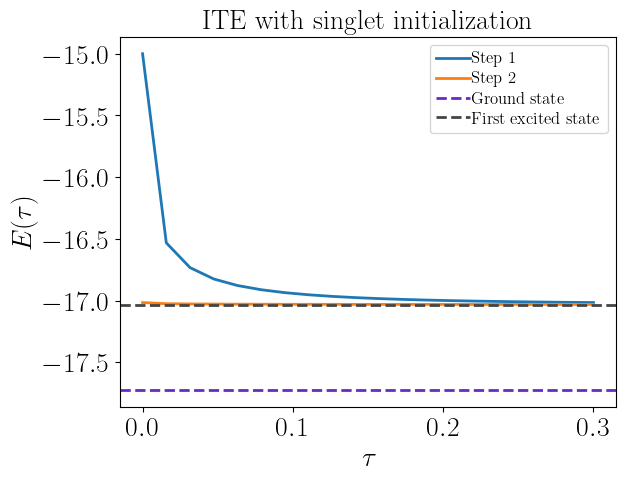

In [15]:
# First step of ITE
s_range = np.linspace(0,0.3, 20)
energies1 = [ITE(psi0, H_matrix, s)[0] for s in s_range]
psi1 = ITE(psi0, H_matrix, s_range[-1])[1]
energies2 = [ITE(psi1, H_matrix, s)[0] for s in s_range]
plt.plot(s_range, energies1, label='Step 1')
plt.plot(s_range, energies2, label='Step 2')
plt.axhline(y=E0, color='#6929C4', linestyle='--', linewidth=2, label='Ground state')
plt.axhline(y=E1, color='#444444', linestyle='--', linewidth=2, label='First excited state')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$E(\tau)$')
plt.legend()
plt.title('ITE with singlet initialization')

### GC

In [49]:
qv = QuantumVariable(L)
QITE(qv, U_0, exp_H, [0.12], 1, method='GC')
qc = qv.qs.compile()
energy = H.get_measurement(qv,precision=0.01,precompiled_qc=qc,diagonalisation_method='commuting')
print(energy)

-16.286012906708027                                                                  


In [57]:
# first step of QITE
method = 'GC'
s_values = np.linspace(0,1,20)
energies = []
energies1 = []
fluctuations = []
for s in s_values:
    qv = QuantumVariable(L)
    QITE(qv, U_0, exp_H_2, [s], 1, method=method)
    qc = qv.qs.compile()
    energies.append(H.get_measurement(qv,precision=0.01,precompiled_qc=qc,diagonalisation_method='commuting'))
# second step of QITE
ind = np.argmin(energies)
s_min = s_values[ind]
for s in s_values:
    qv = QuantumVariable(L)
    QITE(qv, U_0, exp_H_2, [s_min, s], 2, method=method)
    qc = qv.qs.compile()
    energies1.append(H.get_measurement(qv,precision=0.01,precompiled_qc=qc,diagonalisation_method='commuting'))

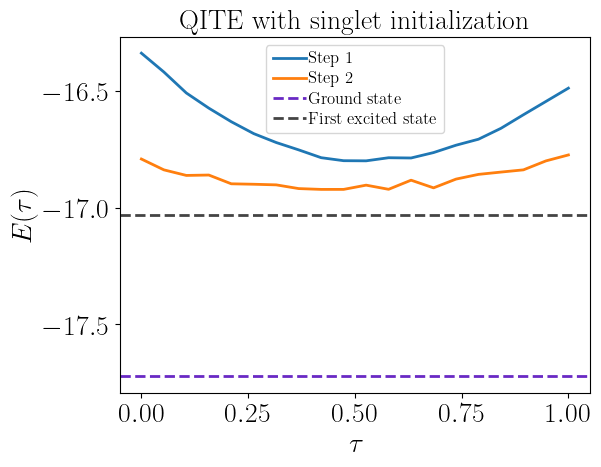

In [58]:
# First step of QITE
plt.plot(s_values, energies, label="Step 1")
plt.plot(s_values, energies1, label="Step 2")
plt.axhline(y=E0, color='#6929C4', linestyle='--', linewidth=2, label='Ground state')
plt.axhline(y=E1, color='#444444', linestyle='--', linewidth=2, label='First excited state')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$E(\tau)$')
plt.legend()
plt.tight_layout()
plt.title('QITE with singlet initialization')
plt.savefig('Figures/QITE_singlet_GC.pdf')


In [ ]:
steps = 4
s_values = np.linspace(.01,1.0,10)

theta = sp.Symbol('theta')
optimal_s_singlet_GC = [theta]
optimal_energies_singlet_GC = [E_0]
circuits_GC = []

for k in range(1,steps+1):
    
    start = time.time()
    
    # Perform k steps of QITE
    qv = QuantumVariable(L)
    QITE(qv, U_0, exp_H, optimal_s_singlet_GC, k, method='GC')
    qc = qv.qs.compile()
    circuits_GC.append(qc)

    # Find optimal evolution time 
    # Use "precompliled_qc" keyword argument to avoid repeated compilation of the QITE circuit
    energies = [H.get_measurement(qv,precision=0.01,subs_dic={theta:s_},precompiled_qc=qc,diagonalisation_method='commuting') for s_ in s_values]
    index = np.argmin(energies)
    s_min = s_values[index]

    optimal_s_singlet_GC.insert(-1,s_min)
    optimal_energies_singlet_GC.append(energies[index])

    end = time.time()
    print(f'Simulating step {k} took {end-start}s')
print('QITE:', optimal_energies_singlet_GC)

/Users/pethidine/anaconda3/envs/qrisp_repo/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/pethidine/anaconda3/envs/qrisp_repo/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Simulating step 1 took 5.181746959686279s                                            
Simulating step 2 took 17.93272614479065s                                            
Simulating step 3 took 51.05032920837402s                                            
Simulating step 4 took 174.59651613235474s                                           
QITE: [-15.013642969421944, -15.396687920646901, -15.592054488190593, -15.770742789502691, -15.929502214623039]


In [91]:
steps = 4
s_values = np.linspace(.01,1.0,10)

theta = sp.Symbol('theta')
optimal_s_singlet_GC_2TS = [theta]
optimal_energies_singlet_GC_2TS = [E_0]
circuits_GC_2TS = []

for k in range(1,steps+1):
    
    start = time.time()
    
    # Perform k steps of QITE
    qv = QuantumVariable(L)
    QITE(qv, U_0, exp_H_2, optimal_s_singlet_GC_2TS, k, method='GC')
    qc = qv.qs.compile()
    circuits_GC_2TS.append(qc)

    # Find optimal evolution time 
    # Use "precompliled_qc" keyword argument to avoid repeated compilation of the QITE circuit
    energies = [H.get_measurement(qv,precision=0.01,subs_dic={theta:s_},precompiled_qc=qc,diagonalisation_method='commuting') for s_ in s_values]
    index = np.argmin(energies)
    s_min = s_values[index]

    optimal_s_singlet_GC_2TS.insert(-1,s_min)
    optimal_energies_singlet_GC_2TS.append(energies[index])

    end = time.time()
    print(f'Simulating step {k} took {end-start}s')
print('QITE:', optimal_energies_singlet_GC_2TS)

/Users/pethidine/anaconda3/envs/qrisp_repo/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/pethidine/anaconda3/envs/qrisp_repo/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Simulating step 1 took 3.475309133529663s                                            
Simulating step 2 took 11.815775156021118s                                           
Simulating step 3 took 34.46380591392517s                                            
Simulating step 4 took 104.2849349975586s                                            
QITE: [-15.013642969421944, -16.463377550763955, -16.780905070653276, -16.890470833238606, -16.975362893826595]


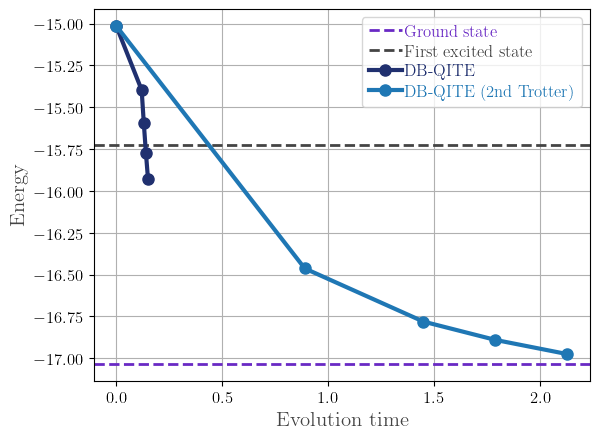

In [95]:
import matplotlib.pyplot as plt

evolution_times_singlet_GC_1TS = [sum(optimal_s_singlet_GC[i] for i in range(k)) for k in range(steps+1)]
evolution_times_singlet_GC_2TS = [sum(optimal_s_singlet_GC_2TS[i] for i in range(k)) for k in range(steps+1)]

plt.xlabel('Evolution time', fontsize=15, color='#444444')
plt.ylabel('Energy', fontsize=15, color='#444444')
plt.axhline(y=E0, color='#6929C4', linestyle='--', linewidth=2, label='Ground state')
plt.axhline(y=E1, color='#444444', linestyle='--', linewidth=2, label='First excited state')
plt.plot(evolution_times_singlet_GC_1TS, optimal_energies_singlet_GC, c='#20306f', marker="o", linestyle='solid', linewidth=3, zorder=3, label='DB-QITE')
plt.plot(evolution_times_singlet_GC_2TS, optimal_energies_singlet_GC_2TS, marker="o", linestyle='solid', linewidth=3, zorder=3, label='DB-QITE (2nd Trotter)')
plt.legend(fontsize=12, labelcolor='linecolor')
plt.tick_params(axis='both', labelsize=12)
plt.grid()
plt.tight_layout()
plt.savefig("B=0singlet_GC_TS_compare.pdf")
plt.show()

## HOPF

In [66]:
# first step of HOPF QITE
s_values = np.linspace(0,1,20)
energies = []
for s in s_values:
    qv = QuantumVariable(L)
    QITE(qv, U_0, exp_H_2, [s], 1, method='HOPF')
    qc = qv.qs.compile()
    energies.append(H.get_measurement(qv,precision=0.01,precompiled_qc=qc,diagonalisation_method='commuting'))

In [67]:
ind = np.argmin(energies)
s_min = s_values[ind]
energies1 = []
for s in s_values:
    qv = QuantumVariable(L)
    QITE(qv, U_0, exp_H_2, [s_min, s], 2, method='HOPF')
    qc = qv.qs.compile()
    energies1.append(H.get_measurement(qv,precision=0.01,precompiled_qc=qc,diagonalisation_method='commuting'))

Text(0.5, 1.0, 'HOPF QITE with singlet initialization')

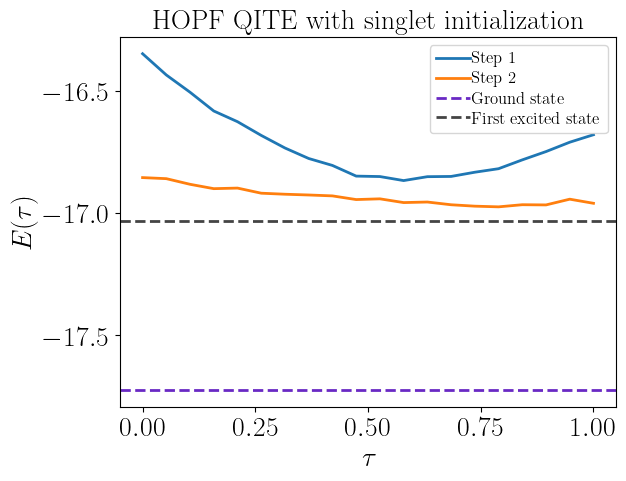

In [68]:
# First step of HOPF QITE
plt.plot(s_values, energies, label="Step 1")
plt.plot(s_values, energies1, label="Step 2")
plt.axhline(y=E0, color='#6929C4', linestyle='--', linewidth=2, label='Ground state')
plt.axhline(y=E1, color='#444444', linestyle='--', linewidth=2, label='First excited state')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$E(\tau)$')
plt.legend()
plt.title('HOPF QITE with singlet initialization')

In [73]:
steps = 2
s_values = np.linspace(.01,0.6,10)

theta = sp.Symbol('theta')
optimal_s = [theta]
optimal_energies = [E_0]

circuits_HOPF = []

for k in range(1,steps+1):

    # Perform k steps of QITE
    qv = QuantumVariable(L)
    QITE(qv, U_0, exp_H_2, optimal_s, k, method='HOPF')
    qc = qv.qs.compile()
    circuits_HOPF.append(qc)

    # Find optimal evolution time 
    # Use "precompliled_qc" keyword argument to avoid repeated compilation of the QITE circuit
    energies = [H.get_measurement(qv,precision=0.01,subs_dic={theta:s_},precompiled_qc=qc,diagonalisation_method='commuting') for s_ in s_values]
    index = np.argmin(energies)
    s_min = s_values[index]

    optimal_s.insert(-1,s_min)
    optimal_energies.append(energies[index])

print(optimal_energies)

/Users/pethidine/anaconda3/envs/qrisp_repo/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/pethidine/anaconda3/envs/qrisp_repo/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


[-16.334992159607953, -16.859855928531584, -16.957629282542758]                      


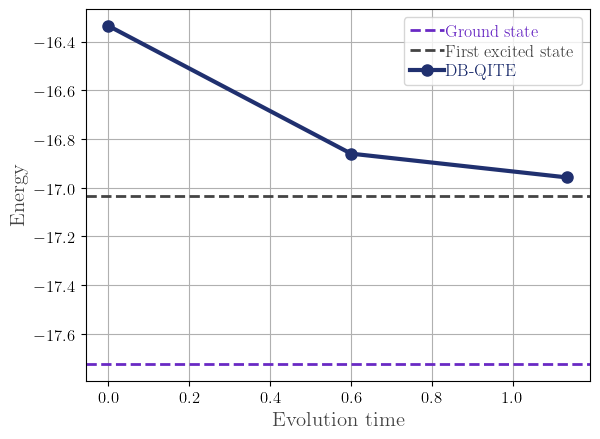

In [75]:
evolution_times = [sum(optimal_s[i] for i in range(k)) for k in range(steps+1)]

plt.xlabel('Evolution time', fontsize=15, color='#444444')
plt.ylabel('Energy', fontsize=15, color='#444444')
plt.axhline(y=E0, color='#6929C4', linestyle='--', linewidth=2, label='Ground state')
plt.axhline(y=E1, color='#444444', linestyle='--', linewidth=2, label='First excited state')
plt.plot(evolution_times, optimal_energies, c='#20306f', marker="o", linestyle='solid', linewidth=3, zorder=3, label='DB-QITE')
plt.legend(fontsize=12, labelcolor='linecolor')
plt.tick_params(axis='both', labelsize=12)
plt.grid()
plt.tight_layout()
plt.savefig("B=1singlet_HOPF.pdf")
plt.show()

## VQE warm start (1 layer)

* 1 layer of problem specific Ansatz: https://arxiv.org/abs/2108.08086, https://qrisp.eu/reference/Algorithms/vqe/vqeProblems/heisenberg.html

In [31]:
from qrisp import QuantumVariable
from qrisp.vqe.problems.heisenberg import *

vqe = heisenberg_problem(G,1,1)
U_0 = vqe.train_function(QuantumVariable(G.number_of_nodes()),depth=1,max_iter=50)

qv= QuantumVariable(G.number_of_nodes())
U_0(qv)
E_0 = H.get_measurement(qv,precision=0.01)
print(E_0)


/Users/pethidine/anaconda3/envs/qrisp_repo/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/pethidine/anaconda3/envs/qrisp_repo/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


-16.334992159607953                                                                  


## GC

In [70]:
# first step of QITE
method = 'GC'
s_values = np.linspace(0,0.2,20)
energies = []
energies1 = []
fluctuations = []
for s in s_values:
    qv = QuantumVariable(L)
    QITE(qv, U_0, exp_H_2, [s], 1, method=method)
    qc = qv.qs.compile()
    energies.append(H.get_measurement(qv,precision=0.01,precompiled_qc=qc,diagonalisation_method='commuting'))
# second step of QITE
ind = np.argmin(energies)
s_min = s_values[ind]
for s in s_values:
    qv = QuantumVariable(L)
    QITE(qv, U_0, exp_H, [s_min, s], 2, method=method)
    qc = qv.qs.compile()
    energies1.append(H.get_measurement(qv,precision=0.01,precompiled_qc=qc,diagonalisation_method='commuting'))

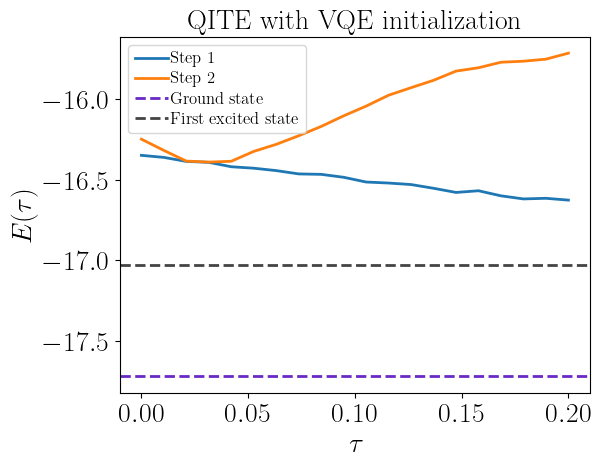

In [72]:
# First step of QITE
plt.plot(s_values, energies, label="Step 1")
plt.plot(s_values, energies1, label="Step 2")
plt.axhline(y=E0, color='#6929C4', linestyle='--', linewidth=2, label='Ground state')
plt.axhline(y=E1, color='#444444', linestyle='--', linewidth=2, label='First excited state')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$E(\tau)$')
plt.legend()
plt.tight_layout()
plt.title('QITE with VQE initialization')
plt.savefig('Figures/QITE_VQE_GC.pdf')

In [ ]:
import numpy as np
import sympy as sp
from qrisp.qite import QITE

steps = 4
s_values = np.linspace(.01,0.1,10)

theta = sp.Symbol('theta')
optimal_s = [theta]
optimal_energies = [E_0]

circuits_VQE_GC = []

for k in range(1,steps+1):

    # Perform k steps of QITE
    qv = QuantumVariable(L)
    QITE(qv, U_0, exp_H, optimal_s, k, method='GC')
    qc = qv.qs.compile()

    circuits_VQE_GC.append(qc)

    # Find optimal evolution time 
    # Use "precompliled_qc" keyword argument to avoid repeated compilation of the QITE circuit
    energies = [H.get_measurement(qv,precision=0.01,subs_dic={theta:s_},precompiled_qc=qc,diagonalisation_method='commuting') for s_ in s_values]
    index = np.argmin(energies)
    s_min = s_values[index]

    optimal_s.insert(-1,s_min)
    optimal_energies.append(energies[index])

print(optimal_energies)

[-16.330119943556372, -16.38814144347904, -16.4732206037322, -16.527158896808224, -16.59059324862686]


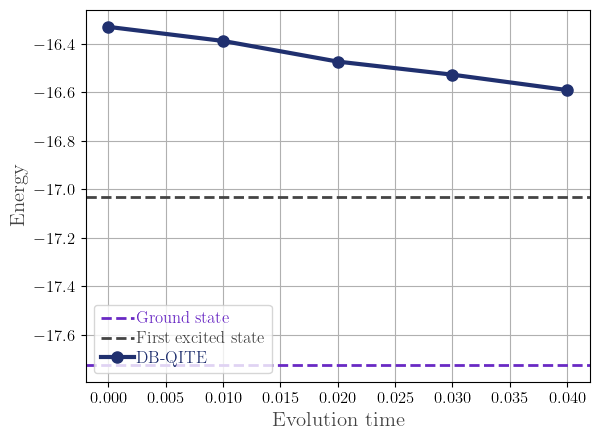

In [40]:
import matplotlib.pyplot as plt

evolution_times = [sum(optimal_s[i] for i in range(k)) for k in range(steps+1)]

plt.xlabel('Evolution time', fontsize=15, color='#444444')
plt.ylabel('Energy', fontsize=15, color='#444444')
plt.axhline(y=E0, color='#6929C4', linestyle='--', linewidth=2, label='Ground state')
plt.axhline(y=E1, color='#444444', linestyle='--', linewidth=2, label='First excited state')
plt.plot(evolution_times, optimal_energies, c='#20306f', marker="o", linestyle='solid', linewidth=3, zorder=3, label='DB-QITE')
plt.legend(fontsize=12, labelcolor='linecolor')
plt.tick_params(axis='both', labelsize=12)
plt.grid()
plt.tight_layout()
plt.savefig("B=VQE_GC.pdf")
plt.show()

## HOPF

In [ ]:
import numpy as np
import sympy as sp
from qrisp.qite import QITE

steps = 3
s_values = np.linspace(.01,1.0,10)

theta = sp.Symbol('theta')
optimal_s = [theta]
optimal_energies = [E_0]

circuits_VQE_HOPF = []

for k in range(1,steps+1):

    # Perform k steps of QITE
    qv = QuantumVariable(L)
    QITE(qv, U_0, exp_H, optimal_s, k, method='HOPF')
    qc = qv.qs.compile()
    circuits_VQE_HOPF.append(qc)

    # Find optimal evolution time 
    # Use "precompliled_qc" keyword argument to avoid repeated compilation of the QITE circuit
    energies = [H.get_measurement(qv,precision=0.01,subs_dic={theta:s_},precompiled_qc=qc,diagonalisation_method='commuting') for s_ in s_values]
    index = np.argmin(energies)
    s_min = s_values[index]

    optimal_s.insert(-1,s_min)
    optimal_energies.append(energies[index])

print(optimal_energies)

In [ ]:
import matplotlib.pyplot as plt

evolution_times = [sum(optimal_s[i] for i in range(k)) for k in range(steps+1)]

plt.xlabel('Evolution time', fontsize=15, color='#444444')
plt.ylabel('Energy', fontsize=15, color='#444444')
plt.axhline(y=H.ground_state_energy(), color='#6929C4', linestyle='--', linewidth=2, label='Exact energy')
plt.axhline(y=H.ground_state_energy()+0.1, color='#444444', linestyle='--', linewidth=2, label='Exact + 0.1')
plt.plot(evolution_times, optimal_energies, c='#20306f', marker="o", linestyle='solid', linewidth=3, zorder=3, label='DB-QITE')
plt.legend(fontsize=12, labelcolor='linecolor')
plt.tick_params(axis='both', labelsize=12)
plt.grid()
plt.show()

## VQE warm start (2 layers)

* 2 layers of problem specific Ansatz: https://arxiv.org/abs/2108.08086, https://qrisp.eu/reference/Algorithms/vqe/vqeProblems/heisenberg.html

In [ ]:
from qrisp import QuantumVariable
from qrisp.vqe.problems.heisenberg import *

vqe = heisenberg_problem(G,1,0)
U_0 = vqe.train_function(QuantumVariable(G.number_of_nodes()),depth=2,max_iter=50)

qv= QuantumVariable(G.number_of_nodes())
U_0(qv)
E_0 = H.get_measurement(qv,precision=0.01)
print(E_0)

## GC

In [ ]:
import numpy as np
import sympy as sp
from qrisp.qite import QITE

steps = 4
s_values = np.linspace(.01,1.0,10)

theta = sp.Symbol('theta')
optimal_s = [theta]
optimal_energies = [E_0]

circuits_VQE_2_GC = []

for k in range(1,steps+1):

    # Perform k steps of QITE
    qv = QuantumVariable(L)
    QITE(qv, U_0, exp_H, optimal_s, k, method='GC')
    qc = qv.qs.compile()

    circuits_VQE_2_GC.append(qc)

    # Find optimal evolution time 
    # Use "precompliled_qc" keyword argument to avoid repeated compilation of the QITE circuit
    energies = [H.get_measurement(qv,precision=0.01,subs_dic={theta:s_},precompiled_qc=qc,diagonalisation_method='commuting') for s_ in s_values]
    index = np.argmin(energies)
    s_min = s_values[index]

    optimal_s.insert(-1,s_min)
    optimal_energies.append(energies[index])

print(optimal_energies)

In [ ]:
import matplotlib.pyplot as plt

evolution_times = [sum(optimal_s[i] for i in range(k)) for k in range(steps+1)]

plt.xlabel('Evolution time', fontsize=15, color='#444444')
plt.ylabel('Energy', fontsize=15, color='#444444')
plt.axhline(y=H.ground_state_energy(), color='#6929C4', linestyle='--', linewidth=2, label='Exact energy')
plt.axhline(y=H.ground_state_energy()+0.1, color='#444444', linestyle='--', linewidth=2, label='Exact + 0.1')
plt.plot(evolution_times, optimal_energies, c='#20306f', marker="o", linestyle='solid', linewidth=3, zorder=3, label='DB-QITE')
plt.legend(fontsize=12, labelcolor='linecolor')
plt.tick_params(axis='both', labelsize=12)
plt.grid()
plt.show()

## HOPF

In [ ]:
import numpy as np
import sympy as sp
from qrisp.qite import QITE

steps = 2
s_values = np.linspace(.01,1.0,10)

theta = sp.Symbol('theta')
optimal_s = [theta]
optimal_energies = [E_0]

circuits_VQE_2_HOPF = []

for k in range(1,steps+1):

    # Perform k steps of QITE
    qv = QuantumVariable(L)
    QITE(qv, U_0, exp_H, optimal_s, k, method='HOPF')
    qc = qv.qs.compile()
    circuits_VQE_2_HOPF.append(qc)

    # Find optimal evolution time 
    # Use "precompliled_qc" keyword argument to avoid repeated compilation of the QITE circuit
    energies = [H.get_measurement(qv,precision=0.01,subs_dic={theta:s_},precompiled_qc=qc,diagonalisation_method='commuting') for s_ in s_values]
    index = np.argmin(energies)
    s_min = s_values[index]

    optimal_s.insert(-1,s_min)
    optimal_energies.append(energies[index])

print(optimal_energies)

In [ ]:
import matplotlib.pyplot as plt

evolution_times = [sum(optimal_s[i] for i in range(k)) for k in range(steps+1)]

plt.xlabel('Evolution time', fontsize=15, color='#444444')
plt.ylabel('Energy', fontsize=15, color='#444444')
plt.axhline(y=H.ground_state_energy(), color='#6929C4', linestyle='--', linewidth=2, label='Exact energy')
plt.axhline(y=H.ground_state_energy()+0.1, color='#444444', linestyle='--', linewidth=2, label='Exact + 0.1')
plt.plot(evolution_times, optimal_energies, c='#20306f', marker="o", linestyle='solid', linewidth=3, zorder=3, label='DB-QITE')
plt.legend(fontsize=12, labelcolor='linecolor')
plt.tick_params(axis='both', labelsize=12)
plt.grid()
plt.show()

## Example: extract information on quantum circuits

In [ ]:
circuits_VQE_GC[1].count_ops()

In [ ]:
circuits_VQE_GC[1].transpile().count_ops()

VQE (1 layer) + GC (2 iterations)

In [ ]:
# We need to bind the symbolic parameter theta to transpile to specific basis gates
qc = circuits_VQE_GC[1]
bqc = qc.bind_parameters(subs_dic={theta:1})
tqc = bqc.transpile(basis_gates=["cx","u"])

print(tqc.count_ops())
print(tqc.num_qubits())
print(tqc.depth())

VQE (1 layer) + GC (4 iterations)

In [ ]:
# We need to bind the symbolic parameter theta to transpile to specific basis gates
qc = circuits_VQE_GC[3]
bqc = qc.bind_parameters(subs_dic={theta:1})
tqc = bqc.transpile(basis_gates=["cx","u"])

print(tqc.count_ops())
print(tqc.num_qubits())
print(tqc.depth())